# importieren wichtige Pakete

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import make_scorer
from numpy.polynomial.polynomial import Polynomial

pd.set_option('display.max_columns', 500)
# für Visualisierung

#plt.rcParams.keys()
plt.rcParams['ytick.labelsize'] = "large"
plt.rcParams['xtick.labelsize'] = "large"
plt.rcParams['axes.labelsize'] = "large"
plt.rcParams['figure.titlesize'] = "x-large"


import warnings
warnings.filterwarnings("ignore")


## Daten lesen und visualisieren

### Load the data and compute RUL

In [2]:
# Laden die Daten FD002 als Beispiel
def read_data(file_name):
    index_columns_names =  ["UnitNumber","Cycle"]
    operational_settings_columns_names = ["Operation Setting "+str(i) for i in range(1,4)]
    sensor_measure_columns_names =["Sensor Measure"+str(i) for i in range(1,22)]
    
    input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names
    
    data = pd.read_csv(file_name, delim_whitespace=True, header=None)
    print("Größe der Daten : Rows {}, Columns {}".format(data.shape[0], data.shape[1]))
    data.columns = input_file_column_names
    return data

In [3]:
def calculate_rul_and_remove_operational (df):
    df['rul'] = df.groupby('UnitNumber')['Cycle'].transform(lambda x: x.max() - x)
    df['rul'] = df['rul'].apply(lambda x: min(x, 130))
    df.drop(['Operation Setting 1','Operation Setting 2','Operation Setting 3', 'Cycle'], axis=1, inplace=True)
    return df

In [5]:
train_data = read_data('./data/train_FD002.txt')
train_data = calculate_rul_and_remove_operational(train_data)
train_data.head()

Größe der Daten : Rows 53759, Columns 26


,UnitNumber,Sensor Measure1,Sensor Measure2,Sensor Measure3,Sensor Measure4,Sensor Measure5,Sensor Measure6,Sensor Measure7,Sensor Measure8,Sensor Measure9,Sensor Measure10,Sensor Measure11,Sensor Measure12,Sensor Measure13,Sensor Measure14,Sensor Measure15,Sensor Measure16,Sensor Measure17,Sensor Measure18,Sensor Measure19,Sensor Measure20,Sensor Measure21,rul
0,1,449.44,555.32,1358.61,1137.23,5.48,8.00,194.64,2222.65,8341.91,1.02,42.02,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071,130
1,1,445.00,549.90,1353.22,1125.78,3.91,5.71,138.51,2211.57,8303.96,1.02,42.20,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665,130
2,1,462.54,537.31,1256.76,1047.45,7.05,9.02,175.71,1915.11,8001.42,0.94,36.69,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723,130
3,1,445.00,549.51,1354.03,1126.38,3.91,5.71,138.46,2211.58,8303.96,1.02,41.96,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701,130
4,1,462.54,537.07,1257.71,1047.93,7.05,9.03,175.05,1915.10,7993.23,0.94,36.89,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286,130


## Schritt 1: Daten Normalisierung und Glättung 

### Entferne Spalten mit konstantem Werten

In [6]:
def identify_and_remove_unique_columns(Dataframe):
    unique_counts = Dataframe.nunique()
    # identify columns with only one unique value and drop them (constant values)
    record_single_unique = pd.DataFrame(unique_counts[unique_counts == 1]).reset_index().rename(columns = {'index': 'feature', 0: 'nunique'})
    to_drop = list(record_single_unique['feature'])
    Dataframe = Dataframe.drop(columns = to_drop)
    return Dataframe

In [7]:
print("Größe vor der Verarbeitung ", train_data.shape)

train_data_relevant = identify_and_remove_unique_columns(train_data)
print("Größe Nach der Verarbeitung", train_data_relevant.shape)

sensor_columns = [col for col in train_data_relevant.columns if 'Sensor Measure' in col]
train_data_relevant.head()

Größe vor der Verarbeitung  (53759, 23)
Größe Nach der Verarbeitung (53759, 23)


,UnitNumber,Sensor Measure1,Sensor Measure2,Sensor Measure3,Sensor Measure4,Sensor Measure5,Sensor Measure6,Sensor Measure7,Sensor Measure8,Sensor Measure9,Sensor Measure10,Sensor Measure11,Sensor Measure12,Sensor Measure13,Sensor Measure14,Sensor Measure15,Sensor Measure16,Sensor Measure17,Sensor Measure18,Sensor Measure19,Sensor Measure20,Sensor Measure21,rul
0,1,449.44,555.32,1358.61,1137.23,5.48,8.00,194.64,2222.65,8341.91,1.02,42.02,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071,130
1,1,445.00,549.90,1353.22,1125.78,3.91,5.71,138.51,2211.57,8303.96,1.02,42.20,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665,130
2,1,462.54,537.31,1256.76,1047.45,7.05,9.02,175.71,1915.11,8001.42,0.94,36.69,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723,130
3,1,445.00,549.51,1354.03,1126.38,3.91,5.71,138.46,2211.58,8303.96,1.02,41.96,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701,130
4,1,462.54,537.07,1257.71,1047.93,7.05,9.03,175.05,1915.10,7993.23,0.94,36.89,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286,130


### Daten Normalisieren mit Z-Score

In [8]:
scaler = StandardScaler()

normalized_train_data = train_data_relevant.copy()
# Normalisierung der Sensormessungeen
normalized_train_data = train_data_relevant.copy()
normalized_train_data[sensor_columns] =  scaler.fit_transform(normalized_train_data[sensor_columns])
normalized_train_data.head()

,UnitNumber,Sensor Measure1,Sensor Measure2,Sensor Measure3,Sensor Measure4,Sensor Measure5,Sensor Measure6,Sensor Measure7,Sensor Measure8,Sensor Measure9,Sensor Measure10,Sensor Measure11,Sensor Measure12,Sensor Measure13,Sensor Measure14,Sensor Measure15,Sensor Measure16,Sensor Measure17,Sensor Measure18,Sensor Measure19,Sensor Measure20,Sensor Measure21,rul
0,1,-0.889378,-0.653071,-0.579176,-0.572622,-0.706177,-0.662907,-0.602496,-0.042898,-0.545819,-0.588083,-0.298598,-0.603008,0.415116,-0.212615,0.021948,-0.705933,-0.515579,-0.039954,0.418187,-0.613958,-0.619148,130
1,1,-1.057627,-0.798422,-0.630051,-0.668741,-1.140622,-1.084502,-0.986938,-0.119202,-0.658830,-0.588083,-0.242911,-0.985404,0.414648,0.067215,0.063719,-0.705933,-0.659701,-0.115645,0.418187,-1.051681,-1.048190,130
2,1,-0.392968,-1.136055,-1.540521,-1.326301,-0.271732,-0.475122,-0.732150,-2.160819,-1.559759,-1.215693,-1.947558,-0.739869,-2.393490,-2.377822,2.087798,-0.705933,-1.416342,-2.159318,-2.391275,-0.679819,-0.641912,130
3,1,-1.057627,-0.808881,-0.622406,-0.663705,-1.140622,-1.084502,-0.987280,-0.119133,-0.658830,-0.588083,-0.317161,-0.983225,0.414257,0.024309,0.030890,-0.705933,-0.695731,-0.115645,0.418187,-1.033443,-1.013808,130
4,1,-0.392968,-1.142491,-1.531554,-1.322271,-0.271732,-0.473281,-0.736670,-2.160888,-1.584148,-1.215693,-1.885683,-0.739215,-2.393724,-2.420728,2.090734,-0.705933,-1.416342,-2.159318,-2.391275,-0.674753,-0.666180,130


### Polynomial fitting

In [9]:
def fit_polynomial(df, degree=6, col_name_unit_number='UnitNumber'):
    def poly_fit(df, degree):
        # This inner function fits a polynomial to each column, returning the fitted values and coefficients.
        fitted_values = {}
        coeffs = {}
        for col in df.columns:
            poly = Polynomial.fit(range(len(df[col])), df[col], degree)
            fitted_values[col] = poly(range(len(df[col])))
            coeffs[col] = poly.coef
        return pd.DataFrame(fitted_values, index=df.index), coeffs
    
    sensor_columns = df.columns.difference([col_name_unit_number])  # Exclude the unit number column
    all_fitted = []
    all_coeffs = {}
    
    for unit in df[col_name_unit_number].unique():
        unit_data = df.loc[df[col_name_unit_number] == unit, sensor_columns]
        fitted_data, coeffs = poly_fit(unit_data, degree)
        all_fitted.append(df.loc[df[col_name_unit_number] == unit].assign(**fitted_data))
        all_coeffs[unit] = coeffs

    return pd.concat(all_fitted, ignore_index=True), all_coeffs


In [10]:
polynomial_train_data = normalized_train_data.copy()
polynomial_train_data[sensor_columns + ['UnitNumber']], polynomials = fit_polynomial(normalized_train_data[sensor_columns + ['UnitNumber']])
polynomial_train_data.head()

,UnitNumber,Sensor Measure1,Sensor Measure2,Sensor Measure3,Sensor Measure4,Sensor Measure5,Sensor Measure6,Sensor Measure7,Sensor Measure8,Sensor Measure9,Sensor Measure10,Sensor Measure11,Sensor Measure12,Sensor Measure13,Sensor Measure14,Sensor Measure15,Sensor Measure16,Sensor Measure17,Sensor Measure18,Sensor Measure19,Sensor Measure20,Sensor Measure21,rul
0,1,-0.708048,-0.880687,-0.971070,-0.882771,-0.620332,-0.676343,-0.739148,-0.947320,-0.988672,-0.819182,-0.947466,-0.738938,-0.766612,-1.019507,0.877422,-0.729224,-0.940264,-0.944785,-0.763561,-0.735919,-0.725784,130
1,1,-0.697391,-0.832441,-0.905480,-0.837560,-0.639061,-0.684798,-0.734630,-0.841823,-0.923871,-0.790553,-0.862825,-0.734526,-0.645500,-0.920497,0.792870,-0.725372,-0.877314,-0.839281,-0.642492,-0.734619,-0.725010,130
2,1,-0.682822,-0.784584,-0.842056,-0.791760,-0.649936,-0.686486,-0.724730,-0.744791,-0.861403,-0.758874,-0.783305,-0.724719,-0.536595,-0.829467,0.713515,-0.715989,-0.816518,-0.742252,-0.533633,-0.727499,-0.718400,130
3,1,-0.664773,-0.737251,-0.780819,-0.745614,-0.653697,-0.682076,-0.710022,-0.655745,-0.801269,-0.724579,-0.708697,-0.710094,-0.439098,-0.745980,0.639154,-0.701657,-0.757886,-0.653218,-0.436185,-0.715167,-0.706562,130
4,1,-0.643657,-0.690567,-0.721785,-0.699345,-0.651046,-0.672200,-0.691052,-0.574226,-0.743466,-0.688081,-0.638800,-0.691194,-0.352243,-0.669614,0.569588,-0.682931,-0.701422,-0.571718,-0.349381,-0.698199,-0.690070,130


## Schritt 2: Feature-Auswahl mit Lasso-Regression

In [16]:
def lasso_feature_selection(X, y, alpha=0.5):
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    return np.array(X.columns)[lasso.coef_ != 0]

In [17]:
selected_features = lasso_feature_selection(polynomial_train_data[sensor_columns], polynomial_train_data['rul'])
selected_features

array(['Sensor Measure1', 'Sensor Measure11', 'Sensor Measure14',
       'Sensor Measure15', 'Sensor Measure16', 'Sensor Measure20'],
      dtype=object)

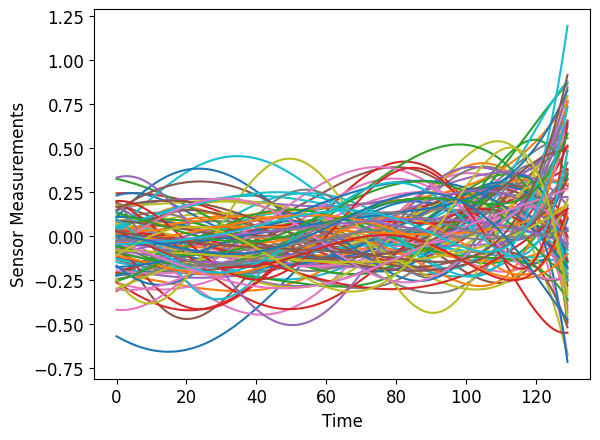

In [18]:
# visualize the smoothed data for unit 1 for each sensor separately
for i in range(101):
    poldata = polynomial_train_data[polynomial_train_data['rul']<130]   
    poly = poldata[poldata['UnitNumber'] == i]['Sensor Measure4']
    plt.plot(range(len(poly)), poly, label='Sensor Measure2_smoothed')
        
plt.xlabel('Time')
plt.ylabel('Sensor Measurements')

plt.show()

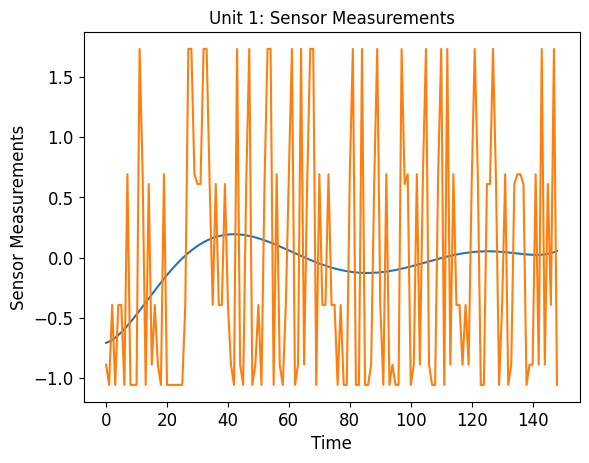

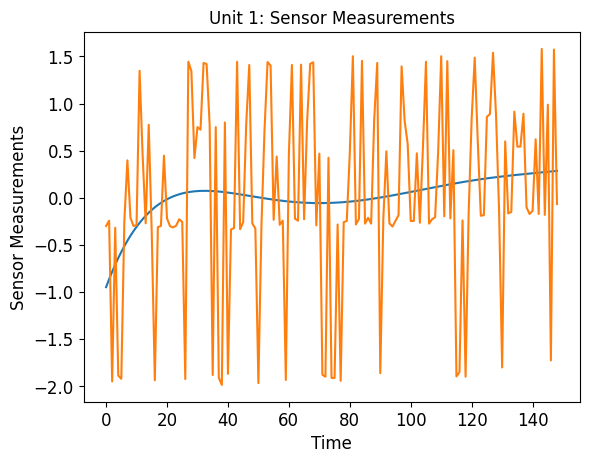

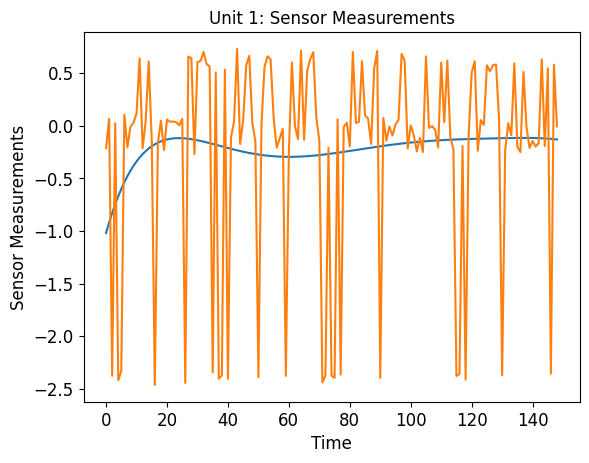

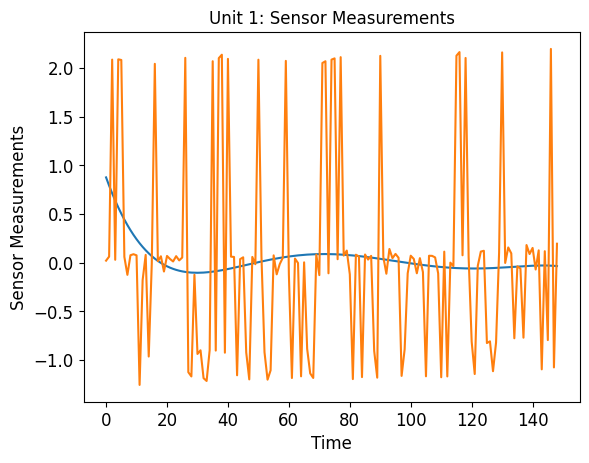

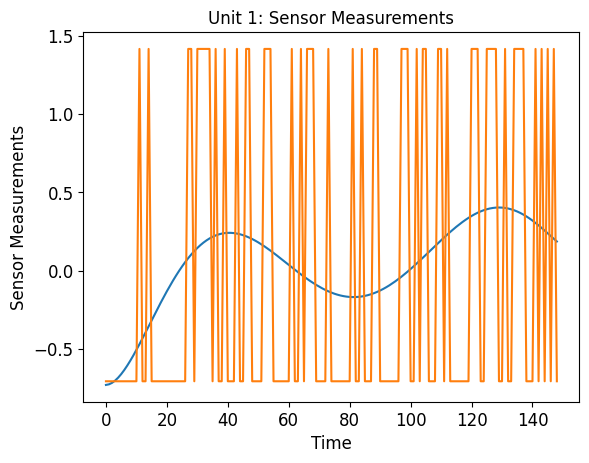

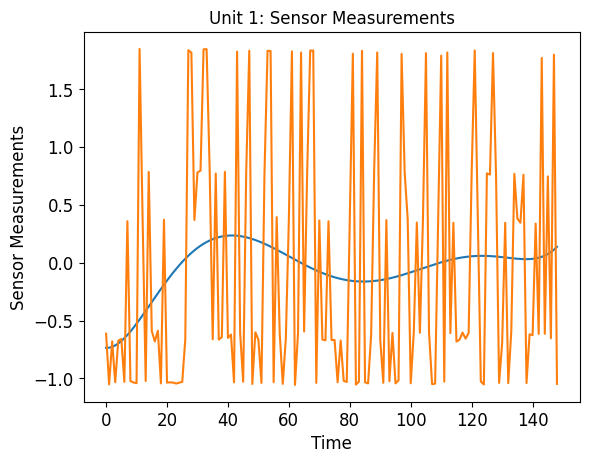

In [19]:
# visualize the unsmoothed and smmothed data for unit 1 for each sensor separately
for col in selected_features:
    plt.plot(polynomial_train_data[polynomial_train_data['UnitNumber'] == 1][col], label=col)
    plt.plot(normalized_train_data[normalized_train_data['UnitNumber'] == 1][col], label=col+'_original')
        
    plt.title('Unit 1: Sensor Measurements')
    plt.xlabel('Time')
    plt.ylabel('Sensor Measurements')
    plt.show()

### Schritt 3: Feature-Extraktion 

In [20]:
selected_polynomial_train_data = polynomial_train_data[[ 'UnitNumber', 'rul']+list(selected_features)]

In [21]:
selected_polynomial_train_data[selected_polynomial_train_data['UnitNumber'] == 1]

,UnitNumber,rul,Sensor Measure1,Sensor Measure11,Sensor Measure14,Sensor Measure15,Sensor Measure16,Sensor Measure20
0,1,130,-0.708048,-0.947466,-1.019507,0.877422,-0.729224,-0.735919
1,1,130,-0.697391,-0.862825,-0.920497,0.792870,-0.725372,-0.734619
2,1,130,-0.682822,-0.783305,-0.829467,0.713515,-0.715989,-0.727499
3,1,130,-0.664773,-0.708697,-0.745980,0.639154,-0.701657,-0.715167
4,1,130,-0.643657,-0.638800,-0.669614,0.569588,-0.682931,-0.698199
...,...,...,...,...,...,...,...,...
144,1,4,0.027113,0.272350,-0.119703,-0.027829,0.256591,0.061911
145,1,3,0.031292,0.275595,-0.121573,-0.028361,0.239274,0.075394
146,1,2,0.037225,0.278935,-0.123879,-0.029473,0.221741,0.092179
147,1,1,0.045165,0.282391,-0.126675,-0.031235,0.204190,0.112669


In [22]:
def extract_features(df, window_length=20, stride=20):
    features = []
    targets = []
    unit_numbers = []
    column_names = [col for col in df.columns if 'Sensor Measure' in col]
    for unit in df['UnitNumber'].unique():
        unit_df = df[df['UnitNumber'] == unit]
        for start in range(len(unit_df) - window_length,0, -stride):
            end = start + window_length 
            window = unit_df.iloc[start:end]

            feature_vector = []
            
            for sensor in column_names:
                mean_val = window[sensor].mean()
                trend = np.polyfit(range(window_length), window[sensor], 1)[0]
                feature_vector.extend([mean_val, trend])
                
                #plt.plot(window[sensor])
                #plt.scatter(start+10, mean_val, color='red', label='Mean Value')
               
            features.append(feature_vector)
            unit_numbers.extend([unit])
            targets.append(unit_df.iloc[end-1]['rul'])
            
    cols = []
    for sensor in column_names:
        cols.extend([sensor + '_mean', sensor + '_trend'])
    return_df = pd.DataFrame(data=np.array(features), columns=cols)
    return_df['UnitNumber'] = unit_numbers
    return return_df, pd.DataFrame(targets, columns=['rul'])

In [23]:
x_train , y_train = extract_features(selected_polynomial_train_data[selected_polynomial_train_data['UnitNumber'] == 1])
x_train.head()

,Sensor Measure1_mean,Sensor Measure1_trend,Sensor Measure11_mean,Sensor Measure11_trend,Sensor Measure14_mean,Sensor Measure14_trend,Sensor Measure15_mean,Sensor Measure15_trend,Sensor Measure16_mean,Sensor Measure16_trend,Sensor Measure20_mean,Sensor Measure20_trend,UnitNumber
0,0.035001,-0.000458,0.254898,0.003248,-0.118277,-0.000476,-0.035920,0.001154,0.323414,-0.011891,0.053554,0.003243,1
1,0.033020,0.003326,0.172724,0.005238,-0.127044,0.001008,-0.053733,-0.000616,0.315820,0.012287,0.041725,0.003089,1
2,-0.078677,0.005822,0.053826,0.006165,-0.165927,0.003104,0.001981,-0.004434,-0.004669,0.015725,-0.090991,0.007769,1
3,-0.100036,-0.004616,-0.039883,0.002583,-0.244503,0.004205,0.077029,-0.002127,-0.146355,-0.002876,-0.134666,-0.004858,1
4,0.074070,-0.010705,-0.029852,-0.003515,-0.287896,-0.000772,0.052285,0.004706,0.059397,-0.014655,0.075135,-0.013591,1


In [24]:
x_train , y_train = extract_features(selected_polynomial_train_data)
pd.concat([x_train, y_train], axis=1).head()

,Sensor Measure1_mean,Sensor Measure1_trend,Sensor Measure11_mean,Sensor Measure11_trend,Sensor Measure14_mean,Sensor Measure14_trend,Sensor Measure15_mean,Sensor Measure15_trend,Sensor Measure16_mean,Sensor Measure16_trend,Sensor Measure20_mean,Sensor Measure20_trend,UnitNumber,rul
0,0.035001,-0.000458,0.254898,0.003248,-0.118277,-0.000476,-0.035920,0.001154,0.323414,-0.011891,0.053554,0.003243,1,0.0
1,0.033020,0.003326,0.172724,0.005238,-0.127044,0.001008,-0.053733,-0.000616,0.315820,0.012287,0.041725,0.003089,1,20.0
2,-0.078677,0.005822,0.053826,0.006165,-0.165927,0.003104,0.001981,-0.004434,-0.004669,0.015725,-0.090991,0.007769,1,40.0
3,-0.100036,-0.004616,-0.039883,0.002583,-0.244503,0.004205,0.077029,-0.002127,-0.146355,-0.002876,-0.134666,-0.004858,1,60.0
4,0.074070,-0.010705,-0.029852,-0.003515,-0.287896,-0.000772,0.052285,0.004706,0.059397,-0.014655,0.075135,-0.013591,1,80.0


## Train Random Forest regressor with C-Fold Cross validation

In [25]:
def custom_score(true_rul, predicted_rul):
    scores = []
    for true, pred in zip(true_rul, predicted_rul):
        if pred < true:
            score = np.exp((true - pred) / 13) - 1
        else:
            score = np.exp((pred - true) / 10) - 1
        scores.append(score)
    mean_score = np.mean(scores)
    return mean_score

# Create the custom scorer
custom_scorer = make_scorer(custom_score, greater_is_better=False)

In [26]:
from sklearn.model_selection import GroupKFold, GridSearchCV

rf_regressor = RandomForestRegressor()
param_grid = {
    'n_estimators': range(10, 101, 10),  # Number of trees in the forest
    'max_samples': np.arange(0.3,1,0.1)  # Minimum number of samples required to be at a leaf node
}

kf = GroupKFold(n_splits=10)
grid_search = GridSearchCV(rf_regressor, param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
#grid_search = GridSearchCV(rf_regressor, param_grid, cv=kf, scoring=custom_score, n_jobs=-1)
#grid_search = GridSearchCV(rf_regressor, param_grid, cv=kf, n_jobs=-1)

grid_search.fit(x_train.drop(['UnitNumber'],axis=1).values, y_train.values.ravel(),groups= x_train['UnitNumber'].values)

best_rf_model = grid_search.best_estimator_

In [27]:
# Predicting on training data
y_train_pred = best_rf_model.predict(x_train.drop(['UnitNumber'], axis=1))
train_error = sqrt(mean_squared_error(y_train, y_train_pred))
train_error

9.755263654314012

In [28]:
best_rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': 0.9000000000000001,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 80,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

## Prediction

In [29]:
#Testdaten laden
test_data =read_data('./data/test_FD002.txt')
test_data = calculate_rul_and_remove_operational(test_data)
test_data.head()

Größe der Daten : Rows 33991, Columns 26


,UnitNumber,Sensor Measure1,Sensor Measure2,Sensor Measure3,Sensor Measure4,Sensor Measure5,Sensor Measure6,Sensor Measure7,Sensor Measure8,Sensor Measure9,Sensor Measure10,Sensor Measure11,Sensor Measure12,Sensor Measure13,Sensor Measure14,Sensor Measure15,Sensor Measure16,Sensor Measure17,Sensor Measure18,Sensor Measure19,Sensor Measure20,Sensor Measure21,rul
0,1,489.05,605.03,1497.17,1304.99,10.52,15.49,394.54,2318.96,8763.80,1.26,45.61,371.69,2388.18,8114.10,8.6476,0.03,369,2319,100.00,28.42,17.1551,130
1,1,491.19,607.82,1481.20,1246.11,9.35,13.66,334.36,2323.95,8713.21,1.08,44.26,315.32,2388.12,8053.06,9.2405,0.02,364,2324,100.00,24.29,14.8039,130
2,1,449.44,556.00,1359.08,1128.36,5.48,8.00,193.55,2222.67,8340.20,1.02,41.80,183.04,2387.75,8053.04,9.3472,0.02,333,2223,100.00,14.98,8.9125,130
3,1,445.00,550.17,1349.69,1127.89,3.91,5.71,138.74,2211.58,8313.85,1.02,42.21,130.40,2387.72,8066.90,9.3961,0.02,332,2212,100.00,10.35,6.4181,130
4,1,462.54,536.72,1253.18,1050.69,7.05,9.03,175.75,1915.10,7997.13,0.94,36.76,164.56,2028.05,7865.66,10.8682,0.02,305,1915,84.93,14.31,8.5740,130


In [30]:
constant_columns=[col for col in test_data.columns if 'Sensor Measure' in col and not col in sensor_columns]
test_data.drop(constant_columns, axis=1, inplace=True)

In [31]:
test_data[sensor_columns] = scaler.transform(test_data[sensor_columns])
test_data.head()

,UnitNumber,Sensor Measure1,Sensor Measure2,Sensor Measure3,Sensor Measure4,Sensor Measure5,Sensor Measure6,Sensor Measure7,Sensor Measure8,Sensor Measure9,Sensor Measure10,Sensor Measure11,Sensor Measure12,Sensor Measure13,Sensor Measure14,Sensor Measure15,Sensor Measure16,Sensor Measure17,Sensor Measure18,Sensor Measure19,Sensor Measure20,Sensor Measure21,rul
0,1,0.611600,0.680028,0.728668,0.835679,0.688475,0.716022,0.766645,0.620355,0.710521,1.294747,0.812051,0.767270,0.418708,0.559923,-0.910220,1.416565,0.745489,0.620627,0.418187,0.773181,0.790616,130
1,1,0.692693,0.754849,0.577930,0.341397,0.364716,0.379114,0.354464,0.654719,0.559870,-0.117376,0.394398,0.357777,0.418240,-0.159573,-0.118978,-0.705933,0.565336,0.655032,0.418187,0.354709,0.393558,130
2,1,-0.889378,-0.634835,-0.574740,-0.647083,-0.706177,-0.662907,-0.609961,-0.042761,-0.550911,-0.588083,-0.366661,-0.603153,0.415351,-0.159808,0.023416,-0.705933,-0.551609,-0.039954,0.418187,-0.588627,-0.601349,130
3,1,-1.057627,-0.791181,-0.663370,-0.651028,-1.140622,-1.084502,-0.985362,-0.119133,-0.629378,-0.588083,-0.239818,-0.985550,0.415116,0.003564,0.088675,-0.705933,-0.587640,-0.115645,0.418187,-1.057761,-1.022589,130
4,1,-0.392968,-1.151877,-1.574312,-1.299102,-0.271732,-0.473281,-0.731876,-2.160888,-1.572534,-1.215693,-1.925902,-0.737399,-2.393334,-2.368510,2.053234,-0.705933,-1.560464,-2.159318,-2.391275,-0.656514,-0.658513,130


In [32]:
test_data[sensor_columns + ['UnitNumber']], polynomials = fit_polynomial(test_data[sensor_columns + ['UnitNumber']])
test_data.head()

,UnitNumber,Sensor Measure1,Sensor Measure2,Sensor Measure3,Sensor Measure4,Sensor Measure5,Sensor Measure6,Sensor Measure7,Sensor Measure8,Sensor Measure9,Sensor Measure10,Sensor Measure11,Sensor Measure12,Sensor Measure13,Sensor Measure14,Sensor Measure15,Sensor Measure16,Sensor Measure17,Sensor Measure18,Sensor Measure19,Sensor Measure20,Sensor Measure21,rul
0,1,-0.187622,-0.206080,-0.278699,-0.241767,-0.209906,-0.218319,-0.226474,-0.179039,-0.265962,-0.189366,-0.207453,-0.225557,-0.118105,-0.363374,0.187679,-0.304522,-0.228205,-0.177412,-0.116566,-0.226160,-0.214914,130
1,1,-0.210827,-0.228943,-0.294786,-0.259936,-0.229265,-0.237843,-0.245892,-0.194201,-0.286315,-0.209064,-0.226447,-0.245096,-0.124095,-0.373633,0.200384,-0.302236,-0.249165,-0.192551,-0.122504,-0.245208,-0.235067,130
2,1,-0.232017,-0.249870,-0.309416,-0.276552,-0.246956,-0.255692,-0.263657,-0.208134,-0.304946,-0.227224,-0.243886,-0.262975,-0.129667,-0.383101,0.212090,-0.300160,-0.268346,-0.206462,-0.128029,-0.262638,-0.253524,130
3,1,-0.251289,-0.268950,-0.322659,-0.291686,-0.263053,-0.271941,-0.279845,-0.220894,-0.321936,-0.243915,-0.259841,-0.279268,-0.134839,-0.391813,0.222841,-0.298282,-0.285830,-0.219203,-0.133157,-0.278522,-0.270362,130
4,1,-0.268731,-0.286269,-0.334579,-0.305408,-0.277630,-0.286665,-0.294527,-0.232536,-0.337361,-0.259201,-0.274381,-0.294048,-0.139630,-0.399803,0.232680,-0.296587,-0.301696,-0.230827,-0.137907,-0.292930,-0.285655,130


In [33]:
test_data = test_data[['UnitNumber', 'rul'] + list(selected_features)].reset_index(drop=True)
test_data.head()

,UnitNumber,rul,Sensor Measure1,Sensor Measure11,Sensor Measure14,Sensor Measure15,Sensor Measure16,Sensor Measure20
0,1,130,-0.187622,-0.207453,-0.363374,0.187679,-0.304522,-0.226160
1,1,130,-0.210827,-0.226447,-0.373633,0.200384,-0.302236,-0.245208
2,1,130,-0.232017,-0.243886,-0.383101,0.212090,-0.300160,-0.262638
3,1,130,-0.251289,-0.259841,-0.391813,0.222841,-0.298282,-0.278522
4,1,130,-0.268731,-0.274381,-0.399803,0.232680,-0.296587,-0.292930


In [34]:
test_data ,  cycle_number = extract_features(test_data)
test_df = pd.concat([test_data, cycle_number], axis=1)
test_df.head()

,Sensor Measure1_mean,Sensor Measure1_trend,Sensor Measure11_mean,Sensor Measure11_trend,Sensor Measure14_mean,Sensor Measure14_trend,Sensor Measure15_mean,Sensor Measure15_trend,Sensor Measure16_mean,Sensor Measure16_trend,Sensor Measure20_mean,Sensor Measure20_trend,UnitNumber,rul
0,0.094809,0.015205,0.158269,0.009647,0.317012,0.009787,0.045040,-0.002733,0.340257,0.009385,0.071967,0.012082,1,0.0
1,0.020551,-0.004336,0.122938,-0.003582,0.208008,0.002412,0.009237,0.004738,0.206630,0.004264,0.014681,-0.003671,1,20.0
2,0.137776,-0.005933,0.206469,-0.003731,0.171434,0.001788,-0.085407,0.004082,0.153656,0.001319,0.116181,-0.005314,1,40.0
3,0.213992,-0.001422,0.241955,0.000336,0.120341,0.003412,-0.135456,0.000834,0.139322,0.000351,0.190790,-0.001894,1,60.0
4,0.197935,0.002737,0.197871,0.003814,0.036849,0.004814,-0.122244,-0.001983,0.128740,0.000863,0.191997,0.001589,1,80.0


In [35]:
def online_rul_prediction(data, rf_model):
    predictions = []
    for unit in data['UnitNumber'].unique():
        unit_data = data[data['UnitNumber'] == unit]
        rul_predictions = rf_model.predict(unit_data.drop(['UnitNumber', 'rul'], axis=1))
        n = len(rul_predictions)
        rul_predictions = rul_predictions - np.array(unit_data['rul'])
        predictions.append(sum(rul_predictions) / n)
        #print("Unit: {}, Average RUL Prediction: {}".format(unit, sum(rul_predictions) / n))
    return predictions


In [36]:
RUL_FD002 = pd.read_table("./data/RUL_FD002.txt", header=None, delim_whitespace=True)
RUL_FD002

,0
0,18
1,79
2,106
3,110
4,15
...,...
254,122
255,191
256,56
257,131


In [37]:
# Predict RUL for test data
predicted_rul = online_rul_prediction(test_df, best_rf_model)

In [38]:
print("Root mean squared error:", sqrt(mean_squared_error(RUL_FD002, predicted_rul)))
print("Custom score:", custom_score(RUL_FD002, predicted_rul))

Root mean squared error: 50.51765429759763
Custom score: 1.212383658570689


In [41]:
last = test_df.groupby('UnitNumber').min(['rul']).drop(['rul'], axis=1)
print("Root mean squared error:", sqrt(mean_squared_error(RUL_FD002, best_rf_model.predict(last))))
print("Custom score:", custom_score(RUL_FD002, predicted_rul))

Root mean squared error: 63.22429830941698
Custom score: 1.212383658570689


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


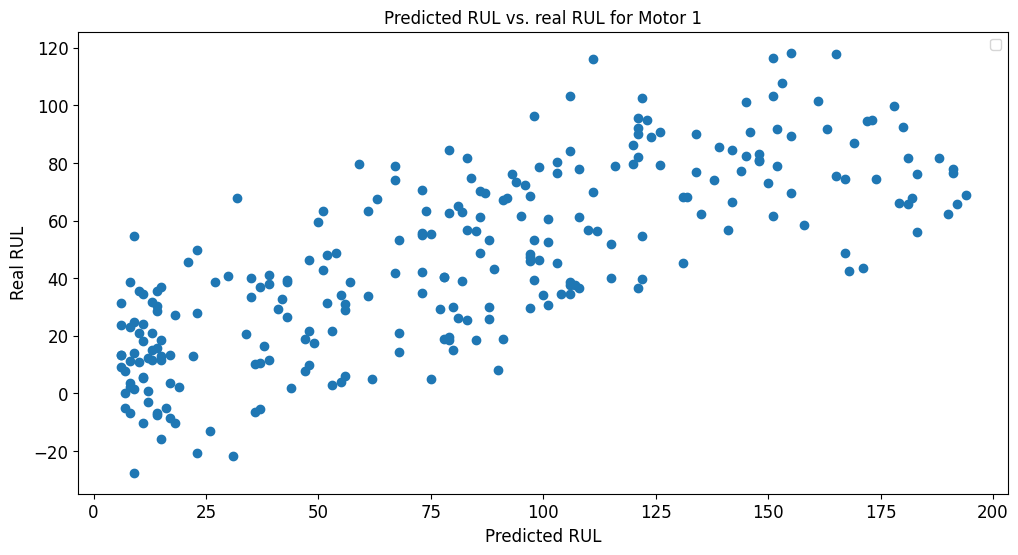

In [40]:
real_rul = pd.read_table("./data/RUL_FD002.txt", header=None, delim_whitespace=True).values

#plot the predicted RUL vs the real RUL for each data point in a scatter plot
plt.figure(figsize=(12,6))

plt.scatter(real_rul, predicted_rul)
plt.legend()
plt.title("Predicted RUL vs. real RUL for Motor 1")
plt.xlabel("Predicted RUL")
plt.ylabel("Real RUL")
plt.show()


## Build a Pipeline including the previous steps
In order to perform a gird search on the hole pipeline and find the best hyperparameters for all steps, we used the Pipeline library from scikit learn. On this pipeline we then could perform a Grid search.

### Define the pipeline for training

#### Step 1: Classes to remove constant columns, normalize the data and do polynomial fitting

In [136]:
class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        X=X.copy()
        X = identify_and_remove_unique_columns(X)
        self.sensor_columns = [col for col in X.columns if 'Sensor Measure' in col]
        self.scaler.fit(X[self.sensor_columns])
        return self

    def transform(self, X):
        X = X.copy()
        X[self.sensor_columns] = self.scaler.transform(X[self.sensor_columns])
        return X 

In [137]:
class PolynomialFitting(BaseEstimator, TransformerMixin):
    def __init__(self, degree=3):
        self.degree = degree

    def fit(self, X, y=None):
        self.sensor_columns = [col for col in X.columns if 'Sensor Measure' in col]
        return self

    def transform(self, X):
        X = X.copy()
        X[self.sensor_columns + ['UnitNumber']], _ = fit_polynomial(X[self.sensor_columns + ['UnitNumber']], degree=self.degree)
        return X

#### Step 2: Class to select relevant features using the Lasso regression

In [138]:
class LassoFeatureSelection(BaseEstimator, TransformerMixin):
    def __init__(self, alpha=0.7):
        self.alpha = alpha
        self.lasso = Lasso(alpha=self.alpha)

    def fit(self, X, y=None):
        x_train=X.copy().drop([ 'UnitNumber', 'rul'], axis=1)
        self.lasso.fit(x_train, X['rul'])
        self.selected_features_ =np.array(X.drop([ 'UnitNumber', 'rul'], axis=1).columns)[(self.lasso.coef_ != 0)]
        return self

    def transform(self, X):
        X=X.copy()
        X = X[[ 'UnitNumber', 'rul'] + list(self.selected_features_)]
        return X

#### Step 3: Class to extract the features using a rolling window with a certain stride

In [139]:
class FeatureExtraction(BaseEstimator, TransformerMixin):
    def __init__(self, window_size=20, stride=20):
        self.window_size = window_size
        self.stride = stride

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        x_train , y_train = extract_features(X, self.window_size, self.stride)
        self.new_labels= y_train
        self.training_data = x_train
        return x_train#pd.concat([x_train,y_train], axis=1)

In [140]:
# Pipeline erstellen
pipeline = Pipeline([
    ('scaler', CustomScaler()),
    ('poly_fit', PolynomialFitting(degree=3)),
    ('lasso_select', LassoFeatureSelection(alpha=2.7)),
    ('feature_extract', FeatureExtraction()),
    ('forest', RandomForestRegressor())
])

### Test the pipeline

#### Load the data

In [266]:
train_data = read_data('./data/train_FD002.txt')
train_data = calculate_rul_and_remove_operational(train_data)

Größe der Daten : Rows 20631, Columns 26


In [267]:
#Testdaten laden
test_data =read_data('./data/test_FD002.txt')
test_data = calculate_rul_and_remove_operational(test_data)
#test_data.head()

Größe der Daten : Rows 13096, Columns 26


### Fit the pipeline on the training dta and test it on the test data

In [271]:
y= extract_feature_labels(train_data)
pipeline.fit(train_data, y)

# Accessing each step of the pipeline
scaler_step = pipeline.named_steps['scaler']
poly_fit_step = pipeline.named_steps['poly_fit']
lasso_select_step = pipeline.named_steps['lasso_select']
feature_extract_step = pipeline.named_steps['feature_extract']
forest_step = pipeline.named_steps['forest']

# Inspecting intermediate results
scaled_data = scaler_step.transform(train_data)
poly_fitted_data = poly_fit_step.transform(scaled_data)
selected_features = lasso_select_step.transform(poly_fitted_data)
extracted_features = feature_extract_step.transform(selected_features)
predicted_rul = forest_step.predict(extracted_features)

In [143]:
scaled_data.head()

,UnitNumber,Sensor Measure1,Sensor Measure2,Sensor Measure3,Sensor Measure4,Sensor Measure5,Sensor Measure6,Sensor Measure7,Sensor Measure8,Sensor Measure9,Sensor Measure10,Sensor Measure11,Sensor Measure12,Sensor Measure13,Sensor Measure14,Sensor Measure15,Sensor Measure16,Sensor Measure17,Sensor Measure18,Sensor Measure19,Sensor Measure20,Sensor Measure21,rul
0,1,518.67,-1.721725,-0.134255,-0.925936,14.62,0.141683,1.121141,-0.516338,-0.862813,1.3,-0.266467,0.334262,-1.058890,-0.269071,-0.603816,0.03,-0.781710,2388,100.0,1.348493,1.194427,130
1,1,518.67,-1.061780,0.211528,-0.643726,14.62,0.141683,0.431930,-0.798093,-0.958818,1.3,-0.191583,1.174899,-0.363646,-0.642845,-0.275852,0.03,-0.781710,2388,100.0,1.016528,1.236922,130
2,1,518.67,-0.661813,-0.413166,-0.525953,14.62,0.141683,1.008155,-0.234584,-0.557139,1.3,-1.015303,1.364721,-0.919841,-0.551629,-0.649144,0.03,-2.073094,2388,100.0,0.739891,0.503423,130
3,1,518.67,-0.661813,-1.261314,-0.784831,14.62,0.141683,1.222827,0.188048,-0.713826,1.3,-1.539489,1.961302,-0.224597,-0.520176,-1.971665,0.03,-0.781710,2388,100.0,0.352598,0.777792,130
4,1,518.67,-0.621816,-1.251528,-0.301518,14.62,0.141683,0.714393,-0.516338,-0.457059,1.3,-0.977861,1.052871,-0.780793,-0.521748,-0.339845,0.03,-0.136018,2388,100.0,0.463253,1.059552,130


In [243]:
poly_fitted_data.head()

,UnitNumber,Sensor Measure1,Sensor Measure2,Sensor Measure3,Sensor Measure4,Sensor Measure5,Sensor Measure6,Sensor Measure7,Sensor Measure8,Sensor Measure9,Sensor Measure10,Sensor Measure11,Sensor Measure12,Sensor Measure13,Sensor Measure14,Sensor Measure15,Sensor Measure16,Sensor Measure17,Sensor Measure18,Sensor Measure19,Sensor Measure20,Sensor Measure21,rul
0,1,518.67,-0.798512,-0.466045,-0.983026,14.62,0.141683,0.930287,-0.569979,-0.687156,1.3,-1.111285,0.870001,-0.773328,-0.552246,-0.970137,0.03,-0.896622,2388.0,100.0,1.015534,1.062681,130
1,1,518.67,-0.794304,-0.472907,-0.980079,14.62,0.141683,0.925949,-0.566511,-0.686939,1.3,-1.100674,0.870436,-0.766315,-0.555730,-0.956198,0.03,-0.892935,2388.0,100.0,1.001607,1.051339,130
2,1,518.67,-0.790239,-0.479704,-0.977208,14.62,0.141683,0.921728,-0.563196,-0.686718,1.3,-1.090309,0.870859,-0.759472,-0.559093,-0.942654,0.03,-0.889361,2388.0,100.0,0.988028,1.040274,130
3,1,518.67,-0.786313,-0.486435,-0.974409,14.62,0.141683,0.917621,-0.560029,-0.686495,1.3,-1.080185,0.871266,-0.752793,-0.562339,-0.929500,0.03,-0.885896,2388.0,100.0,0.974791,1.029482,130
4,1,518.67,-0.782522,-0.493098,-0.971679,14.62,0.141683,0.913625,-0.557005,-0.686270,1.3,-1.070297,0.871655,-0.746275,-0.565470,-0.916729,0.03,-0.882537,2388.0,100.0,0.961891,1.018957,130


In [244]:
selected_features.head()

,UnitNumber,rul,Sensor Measure4,Sensor Measure9,Sensor Measure11
0,1,130,-0.983026,-0.687156,-1.111285
1,1,130,-0.980079,-0.686939,-1.100674
2,1,130,-0.977208,-0.686718,-1.090309
3,1,130,-0.974409,-0.686495,-1.080185
4,1,130,-0.971679,-0.686270,-1.070297


In [245]:
extracted_features.head()

,Sensor Measure4_mean,Sensor Measure4_trend,Sensor Measure9_mean,Sensor Measure9_trend,Sensor Measure11_mean,Sensor Measure11_trend,UnitNumber
0,1.661341,0.044825,-1.013371,-0.006121,1.888744,0.050809,1
1,0.867834,0.034707,-0.904978,-0.004741,1.003459,0.037997,1
2,0.263043,0.025954,-0.822498,-0.003530,0.353596,0.027266,1
3,-0.180334,0.018566,-0.762551,-0.002487,-0.102463,0.018617,1
4,-0.489601,0.012543,-0.721758,-0.001614,-0.406336,0.012048,1


In [268]:
def extract_feature_labels(df, window_length=20, stride=20):
    targets = []
    for unit in df['UnitNumber'].unique():
        unit_df = df[df['UnitNumber'] == unit]
        for start in range(len(unit_df) - window_length,0, -stride):
            end = start + window_length 
            targets.append(unit_df.iloc[end-1]['rul'])
    return pd.DataFrame(targets, columns=['rul'])

In [269]:
def extract_unit_numbers (df, window_length=20, stride=20):
    targets = []
    units =[]
    for unit in df['UnitNumber'].unique():
        unit_df = df[df['UnitNumber'] == unit]
        for start in range(len(unit_df) - window_length,0, -stride):
            end = start + window_length 
            targets.append(unit_df.iloc[end-1]['rul'])
            units.append(unit)
    df_new = pd.DataFrame(targets, columns =['rul'])
    df_new['UnitNumber'] = units
    return df_new.reset_index(drop=True)

In [272]:
# Predicting on training data
train_error = sqrt(mean_squared_error(predicted_rul, extract_feature_labels(train_data)))
train_error

3.761223259994364

In [273]:
# Predicting on training data
y_test_pred = pipeline.predict(test_data)
y_test_pred = pd.concat([pd.DataFrame(y_test_pred), extract_unit_numbers(test_data)], axis=1)
y_test_pred

,0,rul,UnitNumber
0,111.2,0.0,1
1,88.5,0.0,2
2,120.4,20.0,2
3,39.8,0.0,3
4,63.8,20.0,3
...,...,...,...
596,97.9,80.0,100
597,121.7,100.0,100
598,126.4,120.0,100
599,125.8,130.0,100


In [277]:
y = y_test_pred.groupby('UnitNumber').min(['rul']).drop(['rul'], axis=1)

In [278]:
test_error = sqrt(mean_squared_error(y,RUL_FD002))
test_error

25.707281069766985

### Run grid search on the pipeline

In [41]:
param_grid = {
    'poly_fit__degree': np.arange(1, 11),
    'lasso_select__alpha': np.arange(0.1, 3.1, 0.2),
    'feature_extract__window_size': [15,20,15],
    'feature_extract__stride': [1,5,10,20],
    'forest__n_estimators':  np.arange(10, 101,10),
    'forest__max_depth': np.arange(0.3, 1.1, 0.1)
}

In [44]:
from sklearn.base import clone
from sklearn.model_selection import GroupKFold, cross_val_score

def custom_grid_search(df, pipeline, param_grid):
    # Convert parameter grid dictionary to a list of all possible combinations
    from itertools import product
    grid = list(product(*param_grid.values()))
    
    # Prepare to track the best score and corresponding best parameters
    best_score = float('inf')
    best_params = None
    best_model = None
    
    # Iterate over all combinations of parameters
    for params in grid:
        # Set parameters to the pipeline
        current_params = dict(zip(param_grid.keys(), params))
        print(current_params)
        model = clone(pipeline)
        model.set_params(**current_params)
        

        groups = df['UnitNumber'].values
        X = df
        y = df['rul'].values  # This is the target variable

        gkf = GroupKFold(n_splits=5)

        rmse_sum = 0

        for train_idx, test_idx in gkf.split(X, y,  groups=groups):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            #y_train, y_test = y[train_idx], y[test_idx]
            y_train = extract_feature_labels(X_train)
            y_test =  extract_feature_labels(X_test)

        
            pipeline.fit(X_train.reset_index(drop=True), y_train)
            predictions = pipeline.predict(X_test.reset_index(drop=True))
            rmse = sqrt(mean_squared_error(y_test, predictions))
            rmse_sum += rmse
            
        print(f"Average Fold RMSE: {rmse_sum/5}")
        
            # Update best score and parameters if current model is better
        if rmse_sum/5 < best_score:
            best_score = rmse_sum/5
            best_params = current_params
    print('Best score:', best_score)
    print('Best parameters:', best_params)
    
    return best_model, best_score, best_params

In [45]:
custom_grid_search(train_data, pipeline, param_grid)

{'poly_fit__degree': 1, 'lasso_select__alpha': 0.1, 'feature_extract__window_size': 15, 'feature_extract__stride': 1, 'forest__n_estimators': 10, 'forest__max_depth': 0.3}


KeyboardInterrupt: 

### First try to do grid search...

In [129]:
param_grid = {
    #'poly_fit__degree': [9],#np.arange(1, 11),
    #'lasso_select__alpha': [0.1],#np.arange(0.1, 3.1, 0.2),
    #'feature_extract__window_size': [20],
    #'feature_extract__stride': [20],
    'forest__n_estimators': [30,50],
    #'forest__max_depth': [0.6] #np.arange(0.3, 1.1, 0.1)
}

kf = KFold(n_splits=5)
grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1)


grid_search.fit(train_data, labels)#, pipeline.named_steps['feature_extract'].new_labels.values.ravel())
#best_rf_model = grid_search.best_estimator_

ValueError: Found input variables with inconsistent numbers of samples: [20631, 972]